In [1]:
import os
import pickle
import copy

import torch
import torch_geometric
import numpy as np
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from glycowork.glycan_data.loader import lib

from glycontact.lwca import LinearWarmupCosineAnnealingLR
from glycontact.visualize import extract_torsion_angles
from glycontact.learning import GINSweetNet, VonMisesSweetNet, create_dataset, train_model, clean_split, build_baselines, evaluate_model, angular_rmse, value_rmse

# Seed everything for reproducibility
torch_geometric.seed_everything(42)

/home/rjo21/miniconda3/envs/glycontact/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

In [2]:
if not os.path.exists("conformer_split.pkl"):
    multi_train, multi_test = create_dataset()
    with open("conformer_split.pkl", "wb") as f:
        pickle.dump((multi_train, multi_test), f)
else:
    with open("conformer_split.pkl", "rb") as f:
        multi_train, multi_test = pickle.load(f)

# clean_test = clean_split(test, mode="mean")
train = clean_split(multi_train, mode="max")
test = clean_split(multi_test, mode="max")

## Model Training

#### Single Conformer

In [3]:
# Monomer baselines
mean_phi_predictor, mean_psi_predictor, mean_sasa_predictor, mean_flex_predictor = build_baselines([d[1] for d in train], np.mean)
median_phi_predictor, median_psi_predictor, median_sasa_predictor, median_flex_predictor = build_baselines([d[1] for d in train], np.median)

In [4]:
model = GINSweetNet(len(lib), num_classes=4, hidden_dim=256).to("cuda")
optim = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optim, mode="min", factor=0.1, patience=10, threshold=1e-4, cooldown=5, min_lr=1e-6)
metrics, model = train_model(
    model,
    {
        "train": torch_geometric.loader.DataLoader([x[0] for x in train], batch_size=64, shuffle=True),
        "val": torch_geometric.loader.DataLoader([x[0] for x in test], batch_size=64),
    },
    optim,
    scheduler,
    num_epochs=150,
)

Epoch 0/149
----------
train Loss: 10.0886 Phi: 1.4837 Psi: 2.9343 SASA: 224.4379 Flex: 1.9298 LR: 0.0100
val Loss: 37.5868 Phi: 1.2475 Psi: 2.6630 SASA: 181.8925 Flex: 30.6447 LR: 0.0100

Epoch 1/149
----------
train Loss: 9.6409 Phi: 1.4518 Psi: 2.9249 SASA: 222.4477 Flex: 1.5568 LR: 0.0100
val Loss: 10.1425 Phi: 1.2798 Psi: 2.7885 SASA: 198.7408 Flex: 2.7618 LR: 0.0100

Epoch 2/149
----------
train Loss: 9.4343 Phi: 1.4199 Psi: 2.9092 SASA: 220.9959 Flex: 1.4219 LR: 0.0100
val Loss: 9.3077 Phi: 1.2649 Psi: 2.7830 SASA: 205.8268 Flex: 1.8293 LR: 0.0100

Epoch 3/149
----------
train Loss: 9.2696 Phi: 1.3675 Psi: 2.8827 SASA: 218.1727 Flex: 1.3832 LR: 0.0100
val Loss: 9.1368 Phi: 1.2582 Psi: 2.7740 SASA: 207.7468 Flex: 1.6422 LR: 0.0100

Epoch 4/149
----------
train Loss: 9.0816 Phi: 1.2864 Psi: 2.8309 SASA: 215.2817 Flex: 1.3762 LR: 0.0100
val Loss: 9.2426 Phi: 1.1921 Psi: 2.7426 SASA: 206.6543 Flex: 1.8637 LR: 0.0100

Epoch 5/149
----------
train Loss: 8.9198 Phi: 1.2003 Psi: 2.7574 

1671 / 1671


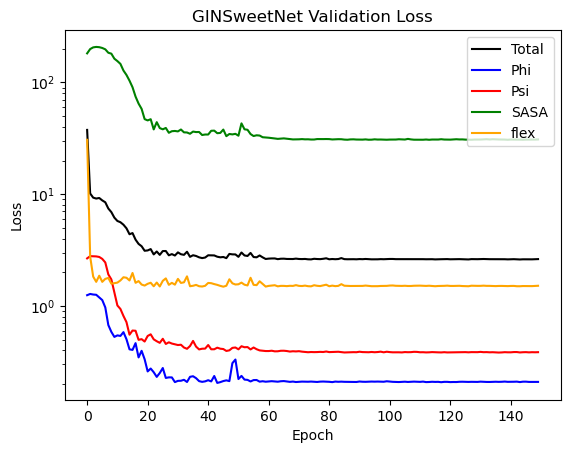

In [5]:
m_psi, m_phi, m_sasa, m_flex, m_pred = evaluate_model(model, multi_test)

plt.plot(metrics["val"]["loss"], c="black", label="Total")
plt.plot(metrics["val"]["phi_loss"], c="blue", label="Phi")
plt.plot(metrics["val"]["psi_loss"], c="red", label="Psi")
plt.plot(metrics["val"]["sasa_loss"], c="green", label="SASA")
plt.plot(metrics["val"]["flex_loss"], c="orange", label="flex")

plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GINSweetNet Validation Loss")

plt.show()

#### Multi-Conformer

In [6]:
# Monomer baselines
multi_mean_phi_predictor, multi_mean_psi_predictor, multi_mean_sasa_predictor, multi_mean_flex_predictor = build_baselines([d[1] for d in multi_train], np.mean)
multi_median_phi_predictor, multi_median_psi_predictor, multi_median_sasa_predictor, multi_median_flex_predictor = build_baselines([d[1] for d in multi_train], np.median)

In [7]:
multi_model = VonMisesSweetNet(len(lib), num_classes=4, hidden_dim=256).to("cuda")
multi_optim = torch.optim.Adam(multi_model.parameters(), lr=0.001)
multi_scheduler = LinearWarmupCosineAnnealingLR(optimizer=multi_optim, warmup_epochs=25, max_epochs=50, warmup_start_lr=1e-5, eta_min=1e-7)
multi_metrics, multi_model = train_model(
    multi_model,
    {
        "train": torch_geometric.loader.DataLoader([x[0] for x in multi_train], batch_size=64, shuffle=True),
        "val": torch_geometric.loader.DataLoader([x[0] for x in multi_test], batch_size=64),
    },
    multi_optim,
    multi_scheduler,
    num_epochs=150,
)

Epoch 0/149
----------
train Loss: 9.6001 Phi: 1.6348 Psi: 1.7786 SASA: 224.7843 Flex: 2.4403 LR: 0.0000
val Loss: 9.3710 Phi: 1.4245 Psi: 1.6938 SASA: 221.2219 Flex: 2.5656 LR: 0.0000

Epoch 1/149
----------
train Loss: 9.0100 Phi: 1.4922 Psi: 1.5505 SASA: 224.7461 Flex: 2.2215 LR: 0.0001
val Loss: 8.4726 Phi: 1.2539 Psi: 1.3475 SASA: 221.1227 Flex: 2.1859 LR: 0.0001

Epoch 2/149
----------
train Loss: 8.2134 Phi: 1.2684 Psi: 1.3552 SASA: 224.5574 Flex: 1.8471 LR: 0.0001
val Loss: 7.4804 Phi: 0.9780 Psi: 1.1782 SASA: 220.8484 Flex: 1.6434 LR: 0.0001

Epoch 3/149
----------
train Loss: 7.2721 Phi: 0.8944 Psi: 1.1662 SASA: 224.2035 Flex: 1.4748 LR: 0.0001
val Loss: 6.7290 Phi: 0.6671 Psi: 0.9496 SASA: 220.4000 Flex: 1.4390 LR: 0.0001

Epoch 4/149
----------
train Loss: 6.6837 Phi: 0.6414 Psi: 0.9855 SASA: 223.8783 Flex: 1.3255 LR: 0.0002
val Loss: 6.4535 Phi: 0.4996 Psi: 0.8450 SASA: 220.0010 Flex: 1.4422 LR: 0.0002

Epoch 5/149
----------
train Loss: 6.3756 Phi: 0.4789 Psi: 0.8970 SASA

1671 / 1671


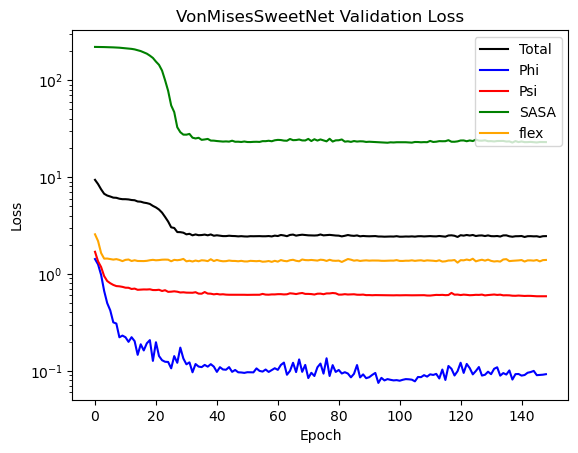

In [8]:
mm_psi, mm_phi, mm_sasa, mm_flex, mm_pred = evaluate_model(multi_model, multi_test)

plt.plot(multi_metrics["val"]["loss"], c="black", label="Total")
plt.plot(multi_metrics["val"]["phi_loss"], c="blue", label="Phi")
plt.plot(multi_metrics["val"]["psi_loss"], c="red", label="Psi")
plt.plot(multi_metrics["val"]["sasa_loss"], c="green", label="SASA")
plt.plot(multi_metrics["val"]["flex_loss"], c="orange", label="flex")

plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VonMisesSweetNet Validation Loss")

plt.show()

# Model evaluation

In [9]:
import numpy as np
import torch
import pandas as pd
import copy
from collections import defaultdict

def compare_torsion_models(models, test_data):
  """
  Compare different models on glycan conformers for torsion angles, SASA and flexibility.
  Args:
    models: Dictionary mapping model names to models (GNNs or baseline functions)
    test_data: List of (pyg_data, nx_graph) tuples from your create_dataset function
  Returns:
    DataFrame with model comparison metrics
  """
  results = {}
  # Group conformers by glycan
  glycan_conformers = defaultdict(list)
  for pyg_data, nx_graph in test_data:
    glycan_id = pyg_data.iupac
    glycan_conformers[glycan_id].append((pyg_data, nx_graph, pyg_data.weight.item()))
  # Evaluate each model
  for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")
    glycan_metrics = {}
    # Process each glycan
    for glycan_id, conformers in glycan_conformers.items():
      # Extract torsion angles, SASA, flexibility and frequencies from conformers
      true_angles = []
      true_sasa = []
      true_flex = []
      frequencies = []
      for _, nx_graph, weight in conformers:
        for node in nx_graph.nodes:
          if "phi_angle" in nx_graph.nodes[node]:
            true_angles.append((nx_graph.nodes[node]["phi_angle"], nx_graph.nodes[node]["psi_angle"]))
            frequencies.append(weight)
          if "SASA" in nx_graph.nodes[node]:
            true_sasa.append(nx_graph.nodes[node]["SASA"])
            true_flex.append(nx_graph.nodes[node]["flexibility"])
      # Normalize frequencies
      total_freq = sum(frequencies)
      frequencies = [f/total_freq for f in frequencies]
      # Get predictions based on model type
      if isinstance(model, VonMisesSweetNet) or isinstance(model, GINSweetNet):
        # Use representative conformer for prediction
        rep_pyg, _, _ = conformers[0]  # Using first conformer as representative
        phi_rmse, psi_rmse, sasa_rmse, flex_rmse = predict_evaluate_gnn(model, rep_pyg, true_angles, true_sasa, true_flex, frequencies)
      elif isinstance(model, tuple) and len(model) == 4:
        # Baseline model (tuple of functions)
        # Extract node info for baseline prediction
        linkage_info = extract_linkage_info(conformers[0][1])
        mono_info = extract_mono_info(conformers[0][1])
        phi_rmse, psi_rmse, sasa_rmse, flex_rmse = predict_evaluate_baseline(model, linkage_info, mono_info, true_angles, true_sasa, true_flex, frequencies)
      else:
        # Custom model
        phi_rmse, psi_rmse, sasa_rmse, flex_rmse = predict_evaluate_custom(model, conformers[0][1], true_angles, true_sasa, true_flex, frequencies)
      # Store metrics for this glycan
      glycan_metrics[glycan_id] = {
        'phi_rmse': phi_rmse,
        'psi_rmse': psi_rmse,
        'sasa_rmse': sasa_rmse,
        'flex_rmse': flex_rmse,
        'avg_torsion_rmse': (phi_rmse + psi_rmse) / 2
      }
    # Calculate average metrics across all glycans
    avg_metrics = {
      'phi_rmse': np.mean([m['phi_rmse'] for m in glycan_metrics.values()]),
      'psi_rmse': np.mean([m['psi_rmse'] for m in glycan_metrics.values()]),
      'sasa_rmse': np.mean([m['sasa_rmse'] for m in glycan_metrics.values()]),
      'flex_rmse': np.mean([m['flex_rmse'] for m in glycan_metrics.values()]),
      'avg_torsion_rmse': np.mean([m['avg_torsion_rmse'] for m in glycan_metrics.values()])
    }
    # Store results for this model
    results[model_name] = {
      'per_glycan': glycan_metrics,
      'average': avg_metrics
    }
  # Create comparison table
  return create_comparison_table(results)

def predict_evaluate_gnn(model, pyg_data, true_angles, true_sasa, true_flex, frequencies):
  """Evaluate GNN model against true values for all metrics"""
  model.eval()
  with torch.no_grad():
    x = pyg_data.x.to("cuda") if torch.cuda.is_available() else pyg_data.x
    edge_index = pyg_data.edge_index.to("cuda") if torch.cuda.is_available() else pyg_data.edge_index
    # Get model predictions
    angular_pred, sasa_pred, flex_pred = model(x, edge_index)
    # Calculate torsion angle metrics based on model type
    if isinstance(model, VonMisesSweetNet):
      weights_logits, mus, kappas = angular_pred
      weights = torch.nn.functional.softmax(weights_logits, dim=2).cpu().numpy()
      mus = mus.cpu().numpy()
      # Calculate angle RMSEs
      phi_squared_errors = []
      psi_squared_errors = []
      for (true_phi, true_psi), freq in zip(true_angles, frequencies):
        min_phi_error = float('inf')
        min_psi_error = float('inf')
        for node_idx in range(weights.shape[0]):
          if has_torsion_angles(pyg_data, node_idx):
            for comp_idx in range(weights.shape[2]):
              phi_err = periodic_distance(true_phi, mus[node_idx, 0, comp_idx])
              psi_err = periodic_distance(true_psi, mus[node_idx, 1, comp_idx])
              min_phi_error = min(min_phi_error, phi_err)
              min_psi_error = min(min_psi_error, psi_err)
        phi_squared_errors.append(min_phi_error**2 * freq)
        psi_squared_errors.append(min_psi_error**2 * freq)
      phi_rmse = np.sqrt(sum(phi_squared_errors))
      psi_rmse = np.sqrt(sum(psi_squared_errors))
    else:  # GINSweetNet
      phi_pred, psi_pred = angular_pred
      phi_squared_errors = []
      psi_squared_errors = []
      for (true_phi, true_psi), freq in zip(true_angles, frequencies):
        min_phi_error = float('inf')
        min_psi_error = float('inf')
        for node_idx in range(len(phi_pred)):
          if has_torsion_angles(pyg_data, node_idx):
            phi_err = periodic_distance(true_phi, phi_pred[node_idx].item())
            psi_err = periodic_distance(true_psi, psi_pred[node_idx].item())
            min_phi_error = min(min_phi_error, phi_err)
            min_psi_error = min(min_psi_error, psi_err)
        phi_squared_errors.append(min_phi_error**2 * freq)
        psi_squared_errors.append(min_psi_error**2 * freq)
      phi_rmse = np.sqrt(sum(phi_squared_errors))
      psi_rmse = np.sqrt(sum(psi_squared_errors))
    # Calculate SASA and flexibility RMSE
    sasa_squared_errors = []
    flex_squared_errors = []
    # For each monosaccharide node
    for true_s, true_f in zip(true_sasa, true_flex):
      min_sasa_error = float('inf')
      min_flex_error = float('inf')
      for node_idx in range(len(sasa_pred)):
        if has_property_values(pyg_data, node_idx):
          sasa_err = abs(true_s - sasa_pred[node_idx].item())
          flex_err = abs(true_f - flex_pred[node_idx].item())
          min_sasa_error = min(min_sasa_error, sasa_err)
          min_flex_error = min(min_flex_error, flex_err)
      sasa_squared_errors.append(min_sasa_error**2)
      flex_squared_errors.append(min_flex_error**2)
    sasa_rmse = np.sqrt(np.mean(sasa_squared_errors))
    flex_rmse = np.sqrt(np.mean(flex_squared_errors))
    return phi_rmse, psi_rmse, sasa_rmse, flex_rmse

def has_torsion_angles(pyg_data, node_idx):
  """Check if a node in PyG data represents a linkage with torsion angles"""
  # This is a placeholder - implement based on your data structure
  if hasattr(pyg_data, 'y') and pyg_data.y is not None:
    return pyg_data.y[node_idx, 0] != 0 or pyg_data.y[node_idx, 1] != 0
  return True

def has_property_values(pyg_data, node_idx):
  """Check if a node in PyG data has SASA and flexibility"""
  # This is a placeholder - implement based on your data structure
  if hasattr(pyg_data, 'y') and pyg_data.y is not None:
    return pyg_data.y[node_idx, 2] != 0 or pyg_data.y[node_idx, 3] != 0
  return True

def extract_linkage_info(nx_graph):
  """Extract information about linkages for baseline prediction"""
  linkage_info = []
  for node in nx_graph.nodes:
    if "phi_angle" in nx_graph.nodes[node]:
      # Get sugar residues connected by this linkage
      pred_res1 = nx_graph.nodes[list(nx_graph.predecessors(node))[0]]["string_labels"]
      pred_res2 = nx_graph.nodes[list(nx_graph.successors(node))[0]]["string_labels"]
      linkage_info.append((pred_res1, pred_res2))
  return linkage_info

def extract_mono_info(nx_graph):
  """Extract monosaccharide information for baseline prediction"""
  mono_info = []
  for node in nx_graph.nodes:
    if "SASA" in nx_graph.nodes[node]:
      # Get monosaccharide label
      mono_label = nx_graph.nodes[node]["string_labels"]
      mono_info.append(mono_label)
  return mono_info

def predict_evaluate_baseline(model, linkage_info, mono_info, true_angles, true_sasa, true_flex, frequencies):
  """Evaluate baseline model (tuple of functions)"""
  phi_fn, psi_fn, sasa_fn, flex_fn = model
  # Calculate torsion angle RMSE
  phi_squared_errors = []
  psi_squared_errors = []
  for (true_phi, true_psi), freq in zip(true_angles, frequencies):
    # Find the best match among predictions for each linkage
    min_phi_error = float('inf')
    min_psi_error = float('inf')
    for linkage in linkage_info:
      pred_phi = phi_fn(linkage)
      pred_psi = psi_fn(linkage)
      phi_err = periodic_distance(true_phi, pred_phi)
      psi_err = periodic_distance(true_psi, pred_psi)
      min_phi_error = min(min_phi_error, phi_err)
      min_psi_error = min(min_psi_error, psi_err)
    # Add weighted squared error
    phi_squared_errors.append(min_phi_error**2 * freq)
    psi_squared_errors.append(min_psi_error**2 * freq)
  # Calculate SASA and flexibility RMSE
  sasa_squared_errors = []
  flex_squared_errors = []
  for true_s, true_f in zip(true_sasa, true_flex):
    min_sasa_error = float('inf')
    min_flex_error = float('inf')
    for mono in mono_info:
      pred_sasa = sasa_fn(mono)
      pred_flex = flex_fn(mono)
      sasa_err = abs(true_s - pred_sasa)
      flex_err = abs(true_f - pred_flex)
      min_sasa_error = min(min_sasa_error, sasa_err)
      min_flex_error = min(min_flex_error, flex_err)
    sasa_squared_errors.append(min_sasa_error**2)
    flex_squared_errors.append(min_flex_error**2)
  # Calculate RMSE
  phi_rmse = np.sqrt(sum(phi_squared_errors))
  psi_rmse = np.sqrt(sum(psi_squared_errors))
  sasa_rmse = np.sqrt(np.mean(sasa_squared_errors))
  flex_rmse = np.sqrt(np.mean(flex_squared_errors))
  return phi_rmse, psi_rmse, sasa_rmse, flex_rmse

def predict_evaluate_custom(model, nx_graph, true_angles, true_sasa, true_flex, frequencies):
  """Evaluate custom model against true values"""
  # This handles any other type of model you might have
  # Implement based on your specific model format
  phi_pred = model["phi_fn"](nx_graph)
  psi_pred = model["psi_fn"](nx_graph)
  sasa_pred = model.get("sasa_fn", lambda _: 0)(nx_graph)
  flex_pred = model.get("flex_fn", lambda _: 0)(nx_graph)
  # Calculate torsion angle RMSE
  phi_squared_errors = []
  psi_squared_errors = []
  for (true_phi, true_psi), freq in zip(true_angles, frequencies):
    phi_err = periodic_distance(true_phi, phi_pred)
    psi_err = periodic_distance(true_psi, psi_pred)
    phi_squared_errors.append(phi_err**2 * freq)
    psi_squared_errors.append(psi_err**2 * freq)
  # Calculate SASA and flexibility RMSE
  sasa_squared_errors = []
  flex_squared_errors = []
  for true_s, true_f in zip(true_sasa, true_flex):
    sasa_err = abs(true_s - sasa_pred)
    flex_err = abs(true_f - flex_pred)
    sasa_squared_errors.append(sasa_err**2)
    flex_squared_errors.append(flex_err**2)
  # Calculate RMSE
  phi_rmse = np.sqrt(sum(phi_squared_errors))
  psi_rmse = np.sqrt(sum(psi_squared_errors))
  sasa_rmse = np.sqrt(np.mean(sasa_squared_errors))
  flex_rmse = np.sqrt(np.mean(flex_squared_errors))
  return phi_rmse, psi_rmse, sasa_rmse, flex_rmse

def periodic_distance(angle1, angle2, period=360):
  """Calculate minimum distance between two angles considering periodicity"""
  return min(abs(angle1 - angle2), period - abs(angle1 - angle2))

def create_comparison_table(results):
  """Create a comparison table from the results"""
  models = list(results.keys())
  metrics = ['phi_rmse', 'psi_rmse', 'avg_torsion_rmse', 'sasa_rmse', 'flex_rmse']
  data = []
  for model in models:
    row = [model]
    for metric in metrics:
      row.append(results[model]['average'][metric])
    data.append(row)
  df = pd.DataFrame(data, columns=['Model'] + metrics)
  return df.sort_values(by='avg_torsion_rmse')

def run_model_comparison(train_data, test_data):
  """Run the model comparison pipeline"""
  # Define your models
  models = {
    "VonMises_GNN": multi_model,
    "Direct_GNN": model,
    "Disaccharide_Mean": build_baselines([d[1] for d in multi_train], np.mean),
    "Disaccharide_Median": build_baselines([d[1] for d in multi_train], np.median)
  }
  # Run comparison
  results = compare_torsion_models(models, test_data)
  print("Model Comparison Results:")
  print(results)
  results.to_csv("torsion_model_comparison.csv", index=False)
  return results

run_model_comparison(multi_train, multi_test)

Evaluating model: VonMises_GNN
Evaluating model: Direct_GNN
Evaluating model: Disaccharide_Mean
Evaluating model: Disaccharide_Median
Model Comparison Results:
                 Model   phi_rmse   psi_rmse  avg_torsion_rmse  sasa_rmse  \
0         VonMises_GNN   7.223283   9.841599          8.532441  14.814556   
1           Direct_GNN  22.912160  25.861716         24.386938  18.687500   
3  Disaccharide_Median  23.738192  28.355725         26.046959  34.772633   
2    Disaccharide_Mean  24.964765  42.815874         33.890320  34.478104   

   flex_rmse  
0   0.593484  
1   0.705009  
3   0.864789  
2   0.930482  


,Model,phi_rmse,psi_rmse,avg_torsion_rmse,sasa_rmse,flex_rmse
0,VonMises_GNN,7.223283,9.841599,8.532441,14.814556,0.593484
1,Direct_GNN,22.912160,25.861716,24.386938,18.687500,0.705009
3,Disaccharide_Median,23.738192,28.355725,26.046959,34.772633,0.864789
2,Disaccharide_Mean,24.964765,42.815874,33.890320,34.478104,0.930482


## Visualize Multi-Conformer VonMisesSweetNet

In [10]:
import random

def ramachandran_plot(
        disaccharide: str, 
        structure_graphs: list[nx.DiGraph],
        density: bool = True,
        ax: plt.Axes = None,
        mode: str = None,
        split: str = None,
        conf: str = None,
    downsample: float = 0.0
) -> plt.Figure:
    """Generate a Ramachandran plot for a specific disaccharide linkage.
    Args:
    disaccharide: String representing the disaccharide (e.g., "Fuc(a1-2)Gal")
    structure_graphs: Dictionary of glycan structure graphs
    density: Whether to show density contours (default: True)
    filepath: Path to save the figure (optional)
    Returns:
    Matplotlib figure object
    """
    if downsample:
        amount = int(np.ceil(len(structure_graphs)*downsample))
        structure_graphs = random.sample(structure_graphs, amount)
    phi_angles, psi_angles = extract_torsion_angles(disaccharide, dict(enumerate(structure_graphs)))
    if not phi_angles or not psi_angles:
        raise ValueError(f"No torsion angles found for disaccharide: {disaccharide}")
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Create density contours if requested
    if density and len(phi_angles) > 3:
        # Calculate the point density
        xy = np.vstack([phi_angles, psi_angles])
        z = stats.gaussian_kde(xy)(xy)
        # Sort the points by density for better visualization
        idx = z.argsort()
        x_sorted, y_sorted, z_sorted = np.array(phi_angles)[idx], np.array(psi_angles)[idx], z[idx]
        # Clear the previous plot and redraw with density coloring
        ax.clear()
        scatter = ax.scatter(x_sorted, y_sorted, c=z_sorted, s=30, cmap='viridis')
        plt.colorbar(scatter, ax=ax, label='Density')
    else:
        # Create the scatter plot
        ax.scatter(phi_angles, psi_angles, alpha=0.7, s=30, c='blue', edgecolor='white')

    # Set plot limits and labels
    ax.set_xlim(-180, 180)
    ax.set_ylim(-180, 180)
    ax.set_xlabel('Phi (°)')
    ax.set_ylabel('Psi (°)')
    ax.set_title(f'Ramachandran Plot for {(mode + " ") if mode else ""}{disaccharide} angles{(" in " + split) if split else ""} {conf} conformers')
    # Add grid lines
    ax.grid(alpha=0.3)
    # Add the origin lines
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    # Add statistics
    stats_text = (
        f"n = {len(phi_angles)}\n"
        f"Mean φ = {np.mean(phi_angles):.1f}° ± {np.std(phi_angles):.1f}°\n"
        f"Mean ψ = {np.mean(psi_angles):.1f}° ± {np.std(psi_angles):.1f}°"
    )
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

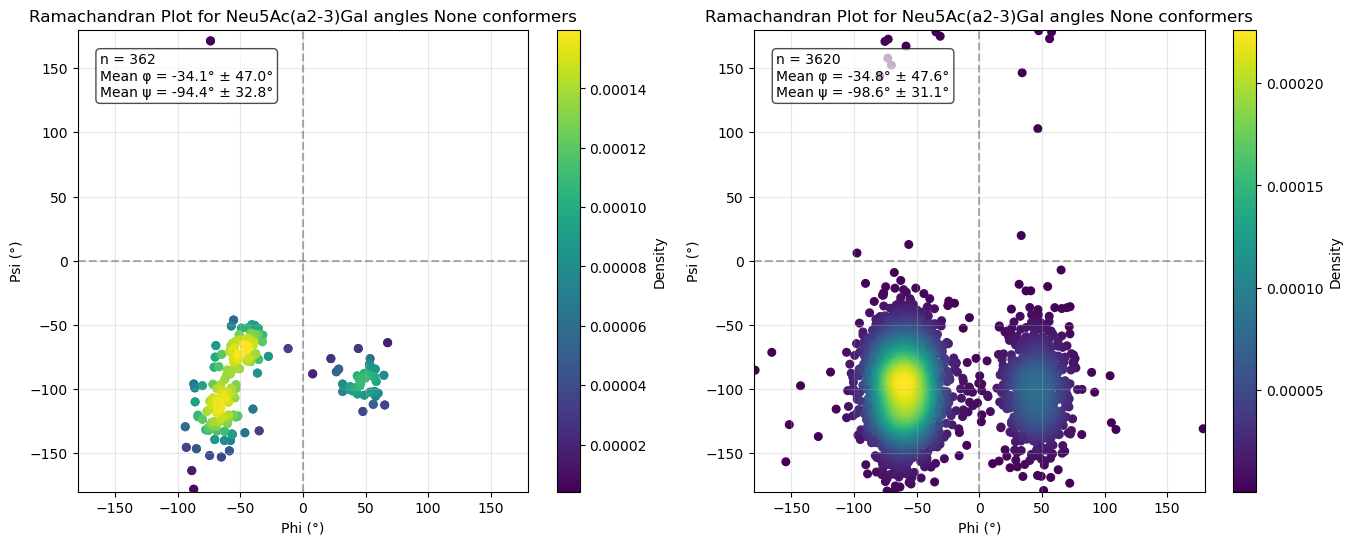

In [11]:
disaccharide = "Neu5Ac(a2-3)Gal"
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide=disaccharide, structure_graphs=[x[1] for x in multi_test], density=True, ax=axs[0])
ramachandran_plot(disaccharide=disaccharide, structure_graphs=mm_pred, density=True, ax=axs[1])

### The same plot with the GINSweetNet, highlighting the difference in generative power.

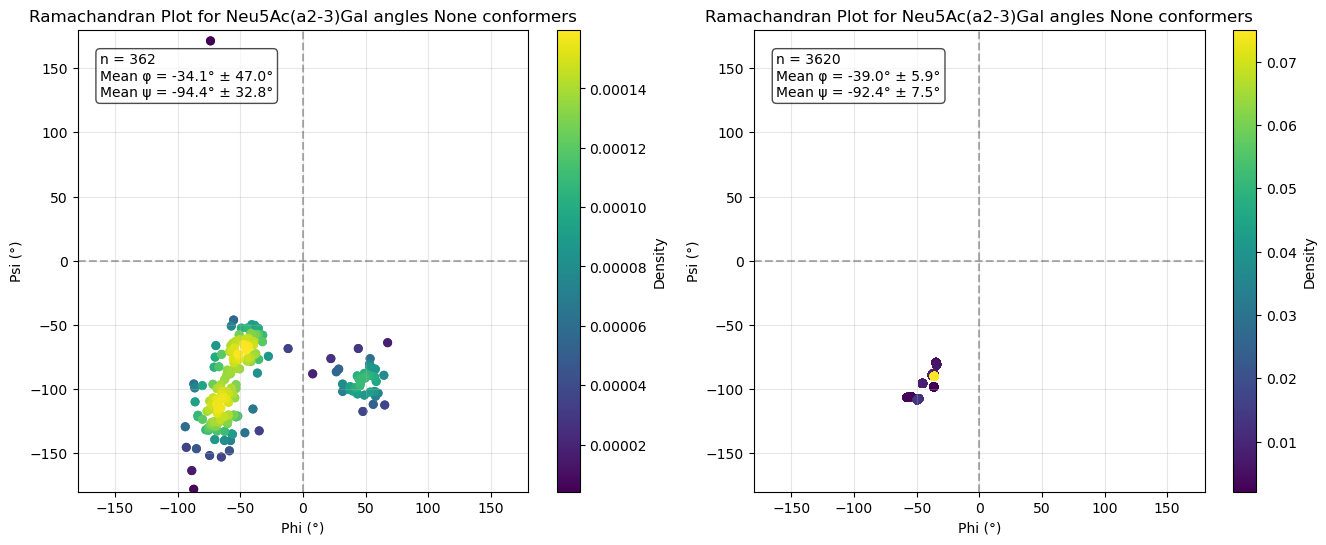

In [12]:
disaccharide = "Neu5Ac(a2-3)Gal"
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide=disaccharide, structure_graphs=[x[1] for x in multi_test], density=True, ax=axs[0])
ramachandran_plot(disaccharide=disaccharide, structure_graphs=m_pred, density=True, ax=axs[1])

## An OOD plot with the VonMisesSweetNet. 

The motif Glc(b1-3)Glc is not contained in any glycan in the training data.

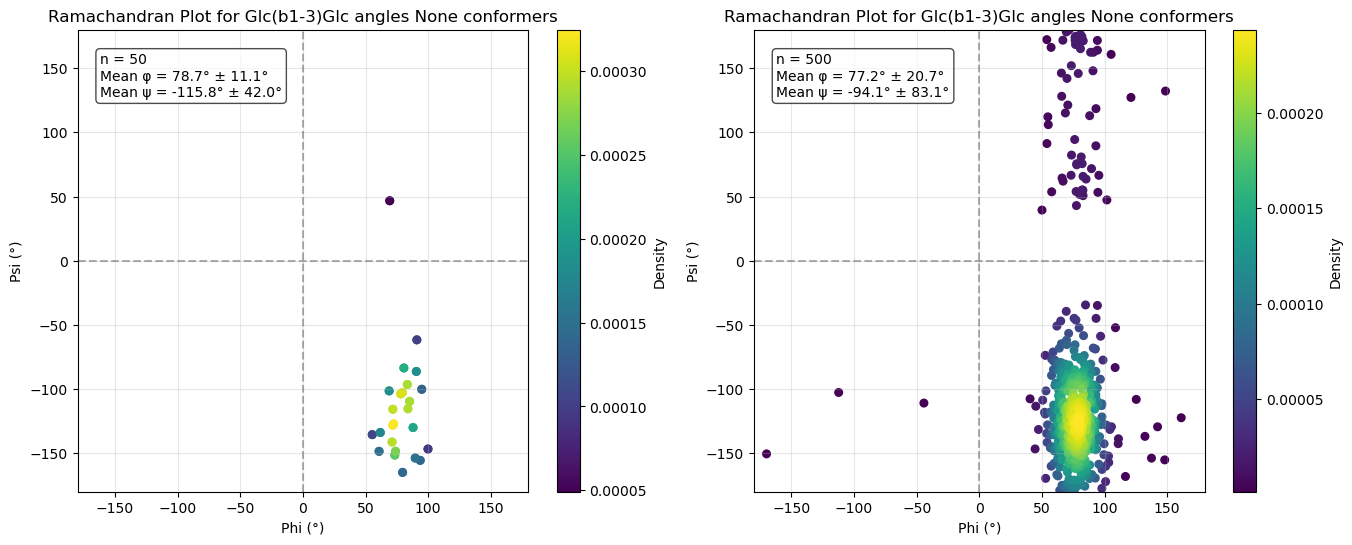

In [13]:
disaccharide = "Glc(b1-3)Glc"
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 2, figure=fig)
axs = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
ramachandran_plot(disaccharide=disaccharide, structure_graphs=[x[1] for x in multi_test], density=True, ax=axs[0])
ramachandran_plot(disaccharide=disaccharide, structure_graphs=mm_pred, density=True, ax=axs[1])
# plt.savefig("ramachandran_Neu5Ac_a23_Gal.pdf", dpi=300, bbox_inches='tight')

## Visualization of scalar properties

In [14]:
def plot_value_distributions(
        true_graphs: list[nx.DiGraph],
        pred_graphs: list[nx.DiGraph],
        value_name: str,
):
    true_values, pred_values = [], []
    for true_graph, pred_graph in zip(true_graphs, pred_graphs):
        for n in true_graph.nodes:
            if value_name in true_graph.nodes[n] and value_name in pred_graph.nodes[n]:
                true_values.append(true_graph.nodes[n][value_name])
                pred_values.append(pred_graph.nodes[n][value_name])
    
    plt.scatter(true_values, pred_values, s=10, marker="o", c="blue")
    print(np.corrcoef(true_values, pred_values)[0, 1])
    plt.xlim(0, min(5 + max(true_values), 1.2 * max(true_values)))
    plt.ylim(0, min(5 + max(pred_values), 1.2 * max(pred_values)))
    plt.xlabel(f"True {value_name}")
    plt.ylabel(f"Predicted {value_name}")

### Solvent-accessible Surface Area (SASA)

0.9418770260296675


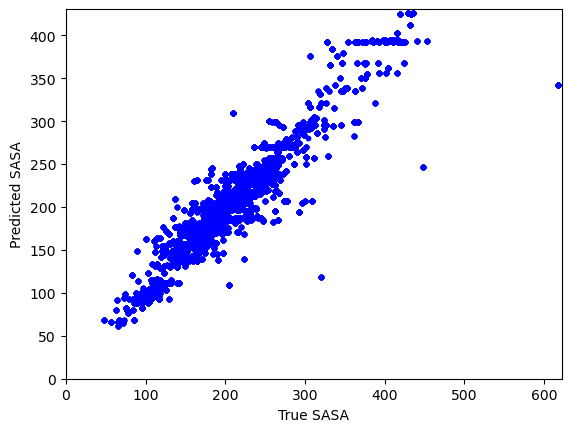

In [15]:
plot_value_distributions(
    [t[1] for t in multi_test], 
    [mm_pred[x] for x in range(0, len(mm_pred), 10)],
    value_name="SASA",
)

### Flexibility

0.504528344270377


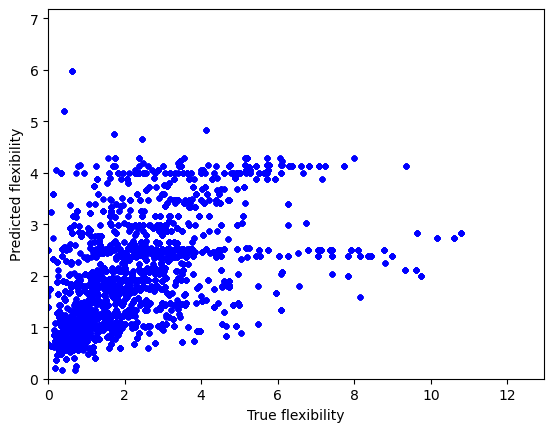

In [16]:
plot_value_distributions(
    [t[1] for t in multi_test], 
    [mm_pred[x] for x in range(0, len(mm_pred), 10)],
    value_name="flexibility",
)